In [1]:
import sys
import pandas as pd
from importlib import reload
import numpy as np
sys.path += ["../src"]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
from glob import glob
import warnings
from IPython.display import display, Latex
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations

In [2]:
sns.set_palette([sns.color_palette("colorblind")[k] for k in [-1,4,2,3]])

In [3]:
sns.color_palette()

[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [4]:
methods = ["svinormal", "sviNF", "mcmc", "abc"]

In [5]:
convert_to_exp = lambda l: [fr"$10^{u}$" if u >= 0 else fr"$0$" for u in l]

In [6]:
# path =  "../data/leaders_exp/est*"
path =  "../data/leaders_240430_2flow/est*"
# path =  "../data/leaders_exp2/est*"
reps = ["1", "2", "3"]
df =  pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in glob(path)]).sort_values("method", ascending = False).assign(rep = lambda x: [u.split("_")[0] for u in x["id"]])#.query("rep in @reps")

In [19]:
import numpy as np

In [22]:
sorted(pd.Series([round(np.random.randint(10) * 0.02 + 0.01, 4) for _ in range(1000)]).unique())

[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]

In [7]:
df.groupby(["N", "T", "initial_leaders_ratio"]).count()["id"].unstack()

initial_leaders_ratio  5.0    10.0   25.0   50.0   100.0
N   T                                                   
50  128                 36.0   36.0   36.0   36.0    NaN
    512                 36.0   36.0   36.0   36.0    NaN
    2048                35.0   36.0   35.0   33.0    NaN
    8192                31.0   28.0   32.0   32.0    NaN
100 128                 36.0   36.0   36.0   36.0   36.0
    512                 36.0   36.0   36.0   36.0   36.0
    2048                34.0   35.0   36.0   34.0   32.0
    8192                32.0   32.0   31.0   29.0   32.0
200 128                 36.0   36.0   36.0   36.0   36.0
    512                 36.0   36.0   36.0   36.0   36.0
    2048                33.0   32.0   30.0   31.0   31.0
    8192                32.0   32.0   31.0   31.0   31.0
400 128                 27.0   27.0   27.0   27.0   27.0
    512                 27.0   27.0   27.0   27.0   27.0
    2048                24.0   24.0   24.0   24.0   24.0
    8192                24.0   24.0   23.0   22.0   22.0

In [8]:
full_id = list(df["id"].value_counts().reset_index().query("count == 4")["id"])
ids_methods = {method: list(df.query("method == @method")["id"]) for method in methods}

print("Total number of combinations", len(df.query("(method == 'svinormal')&(rep == '1')")))
print("Total number of experiments", len(df.query("(method == 'svinormal')&(rep == '1')")) * 3 * 4)
print("Total number of completed experiments", len(df))
print("Experiments completed with all the methods", len(full_id))

Total number of combinations 76
Total number of experiments 912
Total number of completed experiments 2416
Experiments completed with all the methods 457


In [9]:
epsilons = ["epsilon_F_plus", "epsilon_L_plus", "epsilon_F_minus", "epsilon_L_minus"]
methods_names = ["SVI - Normal", "SVI - NF", "MCMC", "ABC"]
patches_methods = [mpatches.Patch(color = sns.color_palette()[j], label = method) for j,method in enumerate(methods_names)]
y_vars = ["accuracy_roles", "rmse_epsilon"]
signs = ["plus", "minus"]
roles = ["F", "L"]

df["n_iter"] = df.fillna(0)["n_steps"] + df.fillna(0)["n_samples"]
df["rmse_epsilon"] = df["mse_epsilon"] ** (0.5)
df["interaction_per_person"] = df["T"] * df["edge_per_t"] / df["N"]
df["diff_epsilon_plus"] = df["epsilon_F_plus_real"] - df["epsilon_L_plus_real"]
df["diff_epsilon_minus"] = -(df["epsilon_F_minus_real"] - df["epsilon_L_minus_real"])
df["error_roles"] = 1 - df["accuracy_roles"]
df["pos_interactions_F"] = df["pos_interactions_F_plus"] + df["pos_interactions_F_minus"]
df["pos_interactions_L"] = df["pos_interactions_L_plus"] + df["pos_interactions_L_minus"]
df["proportion_leaders"] = 1 / df["initial_leaders_ratio"]

for eps in epsilons:
    df[eps + "_in_bound"] = ((df[eps + "_real"] - 2 * df[eps + "_std"]) < df[eps + "_mean"]) & (df[eps + "_mean"] < (df[eps + "_real"] + 2 * df[eps + "_std"]))


In [10]:
vars = {type_var: [u for u in df.columns if type_var in u] for type_var in ["std", "error", "mean", "real", "X", "interaction"]}

In [11]:
dfs = {method: df.query("method == @method").reset_index().drop("index", axis = 1) for method in methods}

### Paper plots

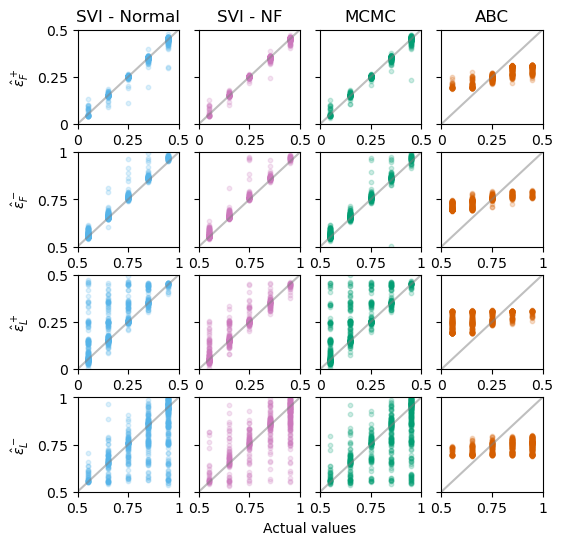

In [12]:
fig, axes = sbp(ncols = 4, nrows = 4, figsize = (6, 6), sharey = "row")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.3)

xs = ["epsilon_F_plus_real", "epsilon_F_minus_real", "epsilon_L_plus_real","epsilon_L_minus_real"]
ys = ["epsilon_F_plus_mean", "epsilon_F_minus_mean", "epsilon_L_plus_mean","epsilon_L_minus_mean"]
ax_lims = [(0,0.5), (0.5,1.)]
ax_ticks = [(0,0.25,0.5), (0.5,0.75,1)]
for i, var_str in enumerate([r"$^+_F$", r"$^-_F$", r"$^+_L$", r"$^-_L$"]):
    for j,method in enumerate(methods):
        axes[i,j].plot(ax_lims[i % 2], ax_lims[i % 2], color = "grey", alpha = 0.5)
        sns.regplot(dfs[method], x = xs[i], y = ys[i], ax = axes[i,j], color = sns.color_palette()[j],fit_reg = False, x_jitter = 0.0, scatter_kws = {"alpha": 0.2, "s": 10})
        axes[i,j].set_xlim(ax_lims[i % 2])
        axes[i,j].set_ylim(ax_lims[i % 2])
            
        axes[0,j].set_title(["SVI - Normal", "SVI - NF", "MCMC", "ABC"][j])
        # axes[i,j].set_xlabel(r"Real $\epsilon$" +  var_str)
        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        axes[i,j].set_xticks(ax_ticks[i % 2], [str(u) for u in ax_ticks[i % 2]])
        axes[i,j].set_yticks(ax_ticks[i % 2], [str(u) for u in ax_ticks[i % 2]])
        # axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # axes[i,0].set_ylabel(r"Estimated $\epsilon$" + var_str)
    axes[i,0].set_ylabel(r"$\hat{\epsilon}$" + var_str)
           
axes[3,0].legend(loc='upper center', bbox_to_anchor=(2.3, -0.43), fancybox=True, ncol=4, handles = patches_methods)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Actual values")

# fig.savefig(f"../paper/scatterplot_extended_bottomlegend.pdf", bbox_inches="tight")

axes[3,0].get_legend().remove()
# fig.savefig(f"../paper/scatterplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()


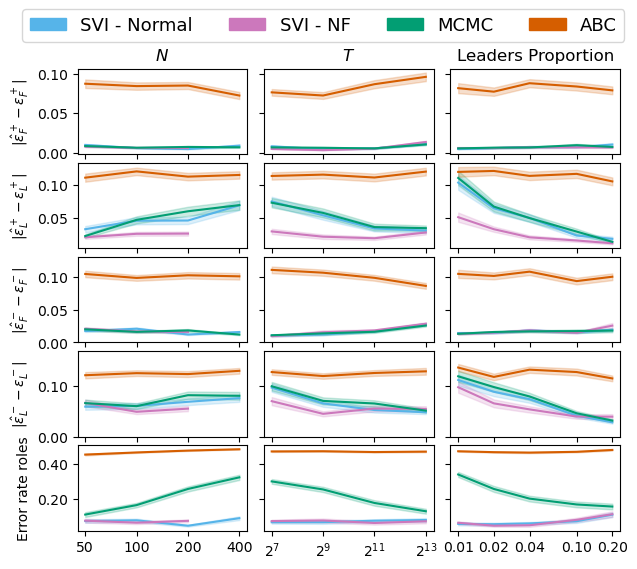

In [13]:
fig, axes = sbp(ncols = 3, nrows = 5, figsize = (7,6), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_N=[50, 100, 200, 400]
x_lab_initial_leaders_ratio = [0.01, 0.02, 0.04, 0.1, 0.2]

for i, y_var in enumerate(vars["error"]):
    for j, x_var in enumerate(["N", "T", "proportion_leaders"]):
        # for method in methods:
            # sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[i,j], errorbar = "se")
        # sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se", palette = colors)
        sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se")
        axes[0,j].set_title([r"$N$", r"$T$", "Leaders Proportion"][j])
        # axes[i,j].set_yscale("log")
        # axes[i,j].set_xticklabels([])
        axes[i,j].set_xscale("log")

        axes[i,j].tick_params(axis = u'both', which = 'minor', length=0)
        axes[i,j].xaxis.set_minor_locator(plt.NullLocator())
        axes[i,j].set_xlabel("")
        axes[i,j].set_xticks([x_lab_N, x_lab_T, x_lab_initial_leaders_ratio][j], 
                             [x_lab_N, x_labT_pow2, x_lab_initial_leaders_ratio][j])
        if i == 2:
            axes[i,j].set_ylim([0, 0.13])
        if i == 3:
            axes[i,j].set_ylim([0, 0.17])
        axes[i,j].get_legend().remove()
        if j < 4:   
            axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if j == 2:
            axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    axes[i,0].set_ylabel([r"$| \hat{\epsilon}^+_F - \epsilon^+_F |$", 
                          r"$| \hat{\epsilon}^+_L - \epsilon^+_L |$", r"$| \hat{\epsilon}^-_F - \epsilon^-_F |$",r"$| \hat{\epsilon}^-_L - \epsilon^-_L |$",
                          "Error rate roles"][i])
    axes[i,1].set_ylabel("")
    axes[i,2].set_ylabel("")
        
axes[4,0].legend(loc='upper center', bbox_to_anchor=(1.45, -0.3), fancybox=True, ncol=4, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

axes[4,0].get_legend().remove()
axes[0,0].legend(loc='upper center', bbox_to_anchor=(1.45, 1.8), fancybox=True, ncol=4, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
# fig.show()

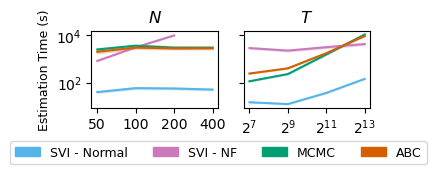

In [14]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (3.6,1), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_N=[50, 100, 200, 400]

y_var = "tot_time"
for j, x_var in enumerate(["N", "T"]):
    # for method in methods:
    #     sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[j], errorbar = "se")
    sns.lineplot(data = df, x = x_var, y = y_var, ax = axes[j], hue = "method", errorbar = "se")
    axes[j].set_title([r"$N$", r"$T$"][j])
    axes[j].set_xscale("log")
    axes[j].set_yscale("log")

    axes[j].tick_params(axis = u'both', which = 'minor', length=0)
    axes[j].xaxis.set_minor_locator(plt.NullLocator())
    axes[j].set_xlabel("")
    axes[j].set_xticks([x_lab_N, x_lab_T, x_lab_initial_leaders_ratio][j], 
                         [x_lab_N, x_labT_pow2, x_lab_initial_leaders_ratio][j])
    axes[j].get_legend().remove()
    
        
axes[0].set_ylabel("Estimation Time (s)", fontsize = 9)
axes[1].set_ylabel("")

axes[1].legend(loc='upper center', bbox_to_anchor=(1.8, 1.1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 12)
# fig.savefig(f"../paper/lineplot_estimation_time_rightlegend.pdf", bbox_inches="tight")

axes[1].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1, -0.35), fancybox=True, ncol=4, handles = patches_methods, fontsize = 9)
# fig.savefig(f"../paper/lineplot_estimation_time_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_estimation_time_nolegend.pdf", bbox_inches="tight")
# fig.show()

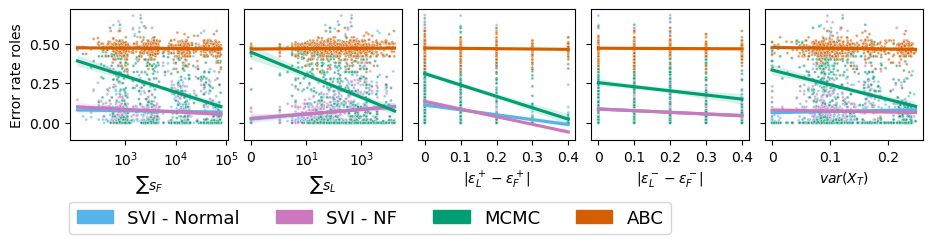

In [15]:
fig, axes = sbp(ncols = 5, nrows = 1, figsize = (11,1.7), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.)

x_vars = ['pos_interactions_F', 'pos_interactions_L', 'diff_epsilon_plus',"diff_epsilon_minus", "var_X_end"]
y_var = "rmse_epsilon"
y_var = "error_roles"

x_ticks_exp = [[3,4,5], [-1,1,3], [0,0.1,0.2,0.3,0.4], [0,0.1,0.2,0.3,0.4], [0,0.1,0.2]]
# y_ticks_exp = [-1, -2]
y_lim = [-2.7, -0.5]
for j, x_var in enumerate(x_vars):
    sns.scatterplot(data = df.assign(
            pos_interactions_F = lambda x:np.log10(x["pos_interactions_F"] + 0.1),
            pos_interactions_L = lambda x:np.log10(x["pos_interactions_L"] + 0.1),
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.)),
            x = x_var, y = y_var, ax = axes[j], marker = ".", size = 0.05, alpha = 0.6, hue = "method")
    for k,method in enumerate(methods):
        sns.regplot(data = df.assign(
            pos_interactions_F = lambda x:np.log10(x["pos_interactions_F"] + 0.1),
            pos_interactions_L = lambda x:np.log10(x["pos_interactions_L"] + 0.1),
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.)).query("method == @method"),
            x = x_var, y = y_var, ax = axes[j], color = sns.color_palette()[k], scatter_kws = {'s': 0})
    axes[j].set_xticks(x_ticks_exp[j], convert_to_exp(x_ticks_exp[j]) if j < 2 else x_ticks_exp[j])
    # axes[j].set_yticks(y_ticks_exp, [r"$10^{-1}$", r"$10^{-2}$"])
    axes[j].set_ylabel("")
    axes[j].set_xlabel("")
    # axes[j].set_ylim(y_lim)
    axes[j].set_xlabel([r"$\sum s_F$", r"$\sum s_L$", r"$|\epsilon^+_L - \epsilon^+_F|$", r"$|\epsilon^-_L - \epsilon^-_F|$", r"$var(X_T)$"][j])
    axes[0].set_ylabel("Error rate roles")
    # axes[0].set_ylabel(r"$RMSE(\hat{\epsilon}^+_F, \hat{\epsilon}^-_F, \hat{\epsilon}^+_L, \hat{\epsilon}^-_L)$")
    axes[j].get_legend().remove()
    
axes[4].legend(loc='upper center', bbox_to_anchor=(1.5, 1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/regplot_rmse_rightlegend.pdf", bbox_inches="tight")

axes[4].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1.9, -0.4), fancybox=True, ncol=4, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/regplot_rmse_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/regplot_rmse_nolegend.pdf", bbox_inches="tight")
# fig.show()

### Quantitative Results

In [16]:
for method in methods:
    print(f"Average RMSE {method} {df.query('(method == @method)')['rmse_epsilon'].mean()}")

print("")

for method in methods:
    print(f"Average RMSE intersection {method} {df.query('(method == @method)&(id in @full_id)')['rmse_epsilon'].mean()}")

print("")
for method in methods:
    print(f"Average error roles {method} {df.query('(method == @method)')['error_roles'].mean()}")
print("")
for method in methods:
    print(f"Exact roles {method} {(df.query('(method == @method)')['error_roles'] == 0).mean()}")

print("")
method = "sviNF"
print(f"Average error roles with filter A {df.query('(method == @method)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['error_roles'].mean()}")
print(f"Average error roles with filter B {df.query('(method == @method)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)&(var_X_end > 0.1)')['error_roles'].mean()}")
print(f"Exact roles with filter A {(df.query('(method == @method)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['error_roles'] == 0).mean()}")
print(f"Exact roles with filter B {(df.query('(method == @method)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)&(var_X_end > 0.1)')['error_roles'] == 0).mean()}")
print("")
for method in methods:
    print(f"Average estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean()}")
print("")
method0 = "svinormal"
for method in methods:
    print(f"Average estimation time vs svinormal estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() / df.query('(id in @full_id)&(method == @method0)')['tot_time'].mean()}")
print("")
method0 = "sviNF"
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average RMSE vs svinNF RMSE {method} {df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean()}")
print("")
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average improvement RMSE vs svinNF RMSE {method} {1 - df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean()}")
print("")
print(f"Average time biggest experiments {df.query('(N == 400)&(T == 8192)')['tot_time'].mean()}")



Average RMSE svinormal 0.050458255871067004
Average RMSE sviNF 0.0373700101170809
Average RMSE mcmc 0.054017182422225474
Average RMSE abc 0.12091330857524232

Average RMSE intersection svinormal 0.04676196040508411
Average RMSE intersection sviNF 0.03767680624400123
Average RMSE intersection mcmc 0.050940539515076
Average RMSE intersection abc 0.12102412922599798

Average error roles svinormal 0.07286587098567951
Average error roles sviNF 0.07219463012973715
Average error roles mcmc 0.21858946136013813
Average error roles abc 0.46986759019893015

Exact roles svinormal 0.3277439024390244
Exact roles sviNF 0.41821946169772256
Exact roles mcmc 0.28440366972477066
Exact roles abc 0.0

Average error roles with filter A 0.023151051253080368
Average error roles with filter B 0.02665442053009482
Exact roles with filter A 0.6666666666666666
Exact roles with filter B 0.6764705882352942

Average estimation time svinormal 50.82359570121348
Average estimation time sviNF 4737.766197071555
Average es

### Latex Macros

In [22]:
print("\sviNFvsABCRMSE", 1 - df.query('(id in @id_inters)&(method == "sviNF")')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == "abc")')['rmse_epsilon'].mean())  
print("\sviNFvsMCMCRMSE", 1 - df.query('(id in @id_inters)&(method == "sviNF")')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == "mcmc")')['rmse_epsilon'].mean())

print("\svinormvssviNFtime", df.query('(id in @full_id)&(method == "sviNF")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())
print("\svinormvsMCMCtime",  df.query('(id in @full_id)&(method == "mcmc")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())
print("\svinormvsABCtime", df.query('(id in @full_id)&(method == "abc")')['tot_time'].mean() / df.query('(id in @full_id)&(method == "svinormal")')['tot_time'].mean())

print("\maxtimesvinorm", df.query('(N == 400)&(T == 8192)')['tot_time'].mean())

print("\ABCthreshold", r"$\ensuremath{5\sqrt{T}}$")
print(r"\npopulations", 1000)
print(r"\nsteps", 800)
print(r"\nsimulations", 5000)
print(r"\nexperiments", 912)
print("\svinormAvgErrorRoles", df.query('(method == "svinormal")')['error_roles'].mean())
print("\sviNFAvgErrorRoles", df.query('(method == "sviNF")')['error_roles'].mean())
print("\mcmcAvgErrorRoles", df.query('(method == "mcmc")')['error_roles'].mean())
print(r"\abcAvgErrorRoles", df.query('(method == "abc")')['error_roles'].mean())
print("\svinormAvgRMSE", df.query('(method == "svinormal")')['rmse_epsilon'].mean())
print("\sviNFAvgRMSE", df.query('(method == "sviNF")')['rmse_epsilon'].mean())
print("\mcmcAvgRMSE", df.query('(method == "mcmc")')['rmse_epsilon'].mean())
print(r"\abcAvgRMSE", df.query('(method == "abc")')['rmse_epsilon'].mean())
print(r"\timeout", "3 hours")


print("\sviNFAvgErrorRolesFilterA", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['error_roles'].mean())
print("\sviNFAvgErrorRolesFilterB", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)&(pos_interactions_L > 10)')['error_roles'].mean())
print("\sviNFAvgRMSEFilterA", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(pos_interactions_L > 10)')['rmse_epsilon'].mean())
print("\sviNFAvgRMSEFilterB", df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)&(pos_interactions_L > 10)')['rmse_epsilon'].mean())


\sviNFvsABCRMSE 0.6575377879175948
\sviNFvsMCMCRMSE 0.04490853845664555
\svinormvssviNFtime 56.04911821438542
\svinormvsMCMCtime 36.92359122703816
\svinormvsABCtime 36.535604073416685
\maxtimesvinorm 60.97735333442688
\ABCthreshold $\ensuremath{5\sqrt{T}}$
\npopulations 1000
\nsteps 800
\nsimulations 5000
\nexperiments 912
\svinormAvgErrorRoles 0.09438597816124297
\sviNFAvgErrorRoles 0.06255953386425972
\mcmcAvgErrorRoles 0.22356726255333215
\abcAvgErrorRoles 0.4702844462708799
\svinormAvgRMSE 0.04383746989069376
\sviNFAvgRMSE 0.03602131412102015
\mcmcAvgRMSE 0.051746219055180516
\abcAvgRMSE 0.12507523972478346
\timeout 3 hours
\sviNFAvgErrorRolesFilterA 0.02866667111714681
\sviNFAvgErrorRolesFilterB 0.018076925323559687
\sviNFAvgRMSEFilterA 0.028462416466234017
\sviNFAvgRMSEFilterB 0.02918460840196332


In [18]:
df.query('(method == "sviNF")&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(var_X_end > 0.1)').sort_values(['error_roles'], ascending = False)[['id', 'accuracy_roles', 'correct_leaders',
       'correct_followers',  
       'epsilon_F_minus_real', 'epsilon_L_minus_real',
       'pos_interactions_L_plus', 'pos_interactions_L_minus',
       'pos_interactions_F_plus', 'pos_interactions_F_minus',
       'tot_interactions_L', 'tot_interactions_F', 'T', 'N', 'edge_per_t',
       'initial_leaders', 'initial_leaders_ratio', 'var_X_end', 'skew_X_end',
       'kurtosis_X_end', 'bimodality_X_end', 'rep', 'n_iter', 'rmse_epsilon',
       'interaction_per_person', 'diff_epsilon_plus', 'diff_epsilon_minus',
       'error_roles']]

,id,accuracy_roles,correct_leaders,correct_followers,epsilon_F_minus_real,epsilon_L_minus_real,pos_interactions_L_plus,pos_interactions_L_minus,pos_interactions_F_plus,pos_interactions_F_minus,...,skew_X_end,kurtosis_X_end,bimodality_X_end,rep,n_iter,rmse_epsilon,interaction_per_person,diff_epsilon_plus,diff_epsilon_minus,error_roles
0,1_50_50_128,0.92,1.0,0.918367,0.55,0.65,6,5,686,340,...,0.658099,-1.034838,0.086772,1,10000,0.099631,25.6,0.2,0.1,0.08
0,0_50_10_8192,0.92,0.2,1.000000,0.65,0.75,2345,2219,25212,16376,...,0.435400,-1.343141,0.137105,0,10000,0.100535,1638.4,0.1,0.1,0.08
0,1_50_25_128,0.96,1.0,0.958333,0.55,0.65,8,9,478,345,...,0.274835,-1.386672,0.068639,1,10000,0.012048,25.6,0.1,0.1,0.04
0,1_50_50_512,0.96,1.0,0.959184,0.55,0.85,43,33,1794,1871,...,0.547743,-1.620529,0.169998,1,10000,0.038163,102.4,0.1,0.3,0.04
0,0_100_100_512,0.97,1.0,0.969697,0.55,0.85,6,5,1330,1446,...,0.105575,-1.617505,0.103985,0,10000,0.040072,51.2,0.1,0.3,0.03
0,1_100_10_512,0.97,1.0,0.966667,0.75,0.85,139,2,1938,333,...,0.161197,-1.179086,0.047201,1,10000,0.010393,51.2,0.1,0.1,0.03
0,1_50_5_128,0.98,1.0,0.975000,0.55,0.85,21,4,272,307,...,0.129529,-1.468042,0.092635,1,10000,0.005089,25.6,0.1,0.3,0.02
0,0_50_10_512,0.98,1.0,0.977778,0.55,0.85,92,90,1433,1613,...,0.447233,-1.652886,0.169998,0,10000,0.007546,102.4,0.1,0.3,0.02
0,1_50_10_512,1.00,1.0,1.000000,0.55,0.95,145,29,2518,1912,...,-0.401110,-1.780182,0.187948,1,10000,0.010332,102.4,0.3,0.4,0.00
0,0_50_10_2048,1.00,1.0,1.000000,0.65,0.95,873,32,10585,5787,...,0.549609,-1.665321,0.179998,0,10000,0.016636,409.6,0.2,0.3,0.00


### Presentation 

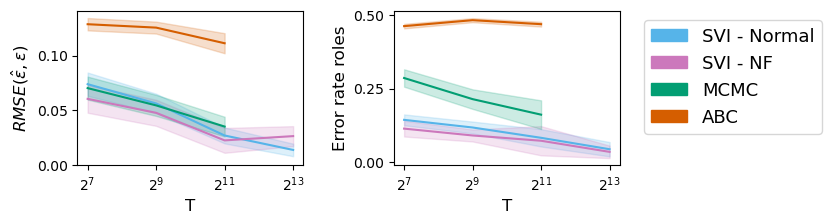

In [19]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.4, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
# x_lab_N=[50, 100, 200, 400]
# x_lab_initial_leaders_ratio = [0.01, 0.02, 0.04, 0.1, 0.2]

x_var = "T"
for j, y_var in enumerate(["rmse_epsilon", "error_roles"]):
    sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[j], errorbar = "se")
    axes[j].set_ylabel([r"$RMSE(\hat{\varepsilon}, \varepsilon)$", r"Error rate roles"][j], fontsize = 12)
    axes[j].set_xlabel(r"T", fontsize = 12)
    axes[j].set_xscale("log")

    axes[j].tick_params(axis = u'both', which = 'minor', length=0)
    axes[j].xaxis.set_minor_locator(plt.NullLocator())
    # axes[j].set_xlabel("")
    axes[j].set_xticks(x_lab_T, x_labT_pow2)
    axes[j].get_legend().remove()
    axes[j].set_yticks([[0,0.05,0.10], [0, 0.25,0.5]][j])
    axes[j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # if j == 2:
    #     axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    # axes[0].set_ylabel([r"RMSE $(| \hat{\varepsilon}, \varepsilon)$", "Error rate roles"][j])
    # axes[j].set_ylabel("")
    
        
axes[1].legend(loc='upper center', bbox_to_anchor=(1.5, 1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

# axes[4,0].get_legend().remove()
# axes[0,0].legend(loc='upper center', bbox_to_anchor=(1.45, 1.8), fancybox=True, ncol=4, handles = patches_methods, fontsize = 13)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()

In [24]:
df.query("(method == 'sviNF')&(N == 50)&(diff_epsilon_plus > 0)&(diff_epsilon_minus > 0)&(T > 511)").mean(numeric_only = True)["accuracy_roles"]

1.0